In [10]:
%matplotlib inline

In [2]:
import torch 
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import pandas as pd

## 1. Loading the data

PyTorch has [dataset class](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html) for MNIST (of course it does!)

Notice that the `ToTensor` transform already normalizes the images to the interval \[0,1\]

In [3]:
train_dataset = datasets.MNIST('../data', transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())

Processing...
Done!


In [4]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)

## 2. Bulding the model

I'm going to make some interesting observations here:

* Based on the examples I've seen so far, I've noticed that it's very common in PyTorch that the last layer of classification network is **not followed by softmax**. This happens because the `nn.CrossEntropyLoss` computes the softmax internally. In test time, if you don't care about the actual probabilities, you just have to do an argmax to get the predictions. If you do care, you can compute the softmax outside the model or even use the `self.training` flag to modify the model behaviour during test time.


* There are some options regarding where to put things like relu, dropout and max pooling. You can define them as layers in the `__init__` method (just like I did with dropout), or use the functional API (as I did with relu and max pool). Both options are identical, and it's just a matter of personal taste, although I was convinced at [this discussion](https://discuss.pytorch.org/t/how-to-choose-between-torch-nn-functional-and-torch-nn-module/2800/16) that a good strategy is to build layers when there are trainable parameters and use the functional API otherwise. I choose to use dropout as a layer because it is stateful in some sense, it has different train/test behaviour. In order to use dropout on the functional API, you have to explicity pass the self.training flag as an argument:

        x = F.dropout(x, training=self.training)
        
Another option is to use `nn.Sequential` to make the model more compact, as a friend of mine did in this [GAN notebook](https://github.com/prcastro/pytorch-gan/blob/master/MNIST%20GAN.ipynb).

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.drop1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64*5*5, 128)
        self.drop2 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64*5*5)
        x = self.drop1(x)
        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        x = self.fc2(x)
        return x        

In [6]:
model = CNN()
model.cuda()

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop1): Dropout(p=0.5)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (drop2): Dropout(p=0.25)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## 3. Loss function and optimizer

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

## 4. Training Loop

This part is a little bit ugly. I don't like writing training loops. Luckily, there is the [torchsample](https://github.com/ncullen93/torchsample) project: it provides a high-level, keras-like API for pytorch models with fit, predict and callbacks. I'm gonna give it a try the next time.

I did a validation step at the end of every epoch.

In [8]:
hist = {'loss': [], 'val_loss': [], 'val_acc': []}
num_epochs = 20
for epoch in range(num_epochs):
    print('Starting epoch {}/{}'.format(epoch+1, num_epochs))
    # train
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]
    
    # evalute
    model.eval()
    val_running_loss = 0.0
    correct = 0
    for images, labels in test_loader:
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        val_running_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels.data).sum()
    
    loss = running_loss / len(train_dataset)
    val_loss, val_acc = val_running_loss / len(test_dataset), correct / len(test_dataset)
    
    hist['loss'].append(loss)
    hist['val_loss'].append(val_loss)
    hist['val_acc'].append(val_acc)
    
    print('loss: {:.4f}  val_loss: {:.4f} val_acc: {:4.4f}\n'.format(loss, val_loss, val_acc))      
    
    

Starting epoch 1/20
loss: 0.0064  val_loss: 0.0002 val_acc: 0.9825

Starting epoch 2/20
loss: 0.0026  val_loss: 0.0001 val_acc: 0.9867

Starting epoch 3/20
loss: 0.0021  val_loss: 0.0001 val_acc: 0.9867

Starting epoch 4/20
loss: 0.0018  val_loss: 0.0001 val_acc: 0.9914

Starting epoch 5/20
loss: 0.0015  val_loss: 0.0001 val_acc: 0.9916

Starting epoch 6/20
loss: 0.0014  val_loss: 0.0001 val_acc: 0.9925

Starting epoch 7/20
loss: 0.0013  val_loss: 0.0001 val_acc: 0.9924

Starting epoch 8/20
loss: 0.0012  val_loss: 0.0001 val_acc: 0.9921

Starting epoch 9/20
loss: 0.0011  val_loss: 0.0001 val_acc: 0.9926

Starting epoch 10/20
loss: 0.0010  val_loss: 0.0001 val_acc: 0.9927

Starting epoch 11/20
loss: 0.0011  val_loss: 0.0001 val_acc: 0.9935

Starting epoch 12/20
loss: 0.0010  val_loss: 0.0001 val_acc: 0.9930

Starting epoch 13/20
loss: 0.0009  val_loss: 0.0001 val_acc: 0.9928

Starting epoch 14/20
loss: 0.0009  val_loss: 0.0001 val_acc: 0.9906

Starting epoch 15/20
loss: 0.0008  val_loss

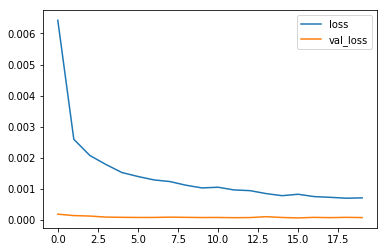

In [9]:
pd.DataFrame(hist)[['loss', 'val_loss']].plot()